In [1]:
import datetime as dt
from datetime import date
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import pyproj
from shapely.ops import transform
import networkx as nx
import momepy

/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
routes = pd.read_csv('data/india/GTFS/routes.txt')

# Number of routes

In [3]:
routes.route_long_name.unique().shape

(1270,)

# Number of stops

In [4]:
stops = pd.read_csv('data/india/GTFS/stops.txt')

In [5]:
stops.stop_id.unique().shape

(4192,)

# Average number of stops per route

This is tricky because we need to associate between route_id and trip_id, but they do not have a dataset that directly connects them. Both do share a dataset with trip_ids however, so the data wrangling part is to:

1. Associate each trip with their stops (some trips might skip some stops)
2. Associate each route with trips on that route
3. For every route, get the unique stops for every trip

In [6]:
trips = pd.read_csv('data/india/GTFS/trips.txt')

In [7]:
stop_times = pd.read_csv('data/india/GTFS/stop_times.txt')

In [8]:
trip_to_stop_id = stop_times[['trip_id', 'stop_id']].drop_duplicates()
trip_to_stop_id

,trip_id,stop_id
0,1_07_00,23
1,1_07_00,24
2,1_07_00,25
3,1_07_00,26
4,1_07_00,27
...,...,...
2250285,1268_21_30,371
2250286,1268_21_30,372
2250287,1268_21_30,1736
2250288,1268_21_30,1738


In [9]:
route_to_trip_id = trips[['route_id', 'trip_id']].drop_duplicates()
route_to_trip_id

,route_id,trip_id
0,0,0_20_20
1,0,0_20_30
2,0,0_20_40
3,0,0_20_50
4,0,0_21_00
...,...,...
50350,9,9_21_10
50351,9,9_21_20
50352,9,9_21_30
50353,9,9_21_40


In [10]:
def f(x):
    '''
    input: dataframe with columns trip_id and stop_id. the trip_id has only one unique value
    output: list of all stop ids that this trip stops at
    '''
    return x.stop_id.to_list()

trip_stops = trip_to_stop_id.groupby('trip_id').apply(f)
trip_stops

trip_id
0_20_20    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_20_30    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_20_40    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_20_50    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
0_21_00    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
                                 ...                        
9_21_10    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_20    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_30    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_40    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
9_21_50    [239, 240, 241, 242, 243, 244, 245, 246, 247, ...
Length: 50355, dtype: object

In [11]:
def g(x):
    '''Same as `f` above but collects trip ids instead of stop ids'''
    return x.trip_id.to_list()

route_trips = route_to_trip_id.groupby('route_id').apply(g)
route_trips

route_id
0       [0_20_20, 0_20_30, 0_20_40, 0_20_50, 0_21_00, ...
1       [1_07_00, 1_07_10, 1_07_20, 1_07_30, 1_07_40, ...
2                                      [2_06_10, 2_06_20]
3       [3_10_30, 3_10_50, 3_11_10, 3_11_20, 3_11_30, ...
4       [4_06_00, 4_06_10, 4_06_50, 4_07_00, 4_07_10, ...
                              ...                        
1265    [1265_06_00, 1265_06_10, 1265_06_20, 1265_06_3...
1266    [1266_06_10, 1266_06_30, 1266_07_20, 1266_07_3...
1267    [1267_06_20, 1267_06_30, 1267_06_40, 1267_06_5...
1268    [1268_14_30, 1268_14_50, 1268_15_00, 1268_15_5...
1269    [1269_17_40, 1269_17_50, 1269_18_10, 1269_18_3...
Length: 1187, dtype: object

In [12]:
def h(x):
    '''
    input: a list of trip_ids (a single route has multiple trips)
    output: the set of stop_ids that every trip stops at
    '''
    result = set()
    for trip_id in x:
        result.update(trip_stops[trip_id])
    return result

route_to_stops = route_trips.apply(h)
route_to_stops

route_id
0       {3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
1       {23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...
2                            {69, 70, 71, 72, 73, 74, 75}
3       {76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...
4       {24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...
                              ...                        
1265    {2069, 415, 416, 2593, 417, 418, 419, 1340, 27...
1266    {1296, 1297, 1298, 1299, 1300, 1301, 1302, 161...
1267    {665, 829, 830, 831, 832, 833, 834, 835, 836, ...
1268    {3109, 2153, 2154, 2155, 2156, 2157, 2158, 111...
1269    {2439, 392, 393, 394, 395, 396, 397, 398, 399,...
Length: 1187, dtype: object

In [13]:
num_stops_for_every_route = route_to_stops.apply(len)
num_stops_for_every_route

route_id
0       20
1       46
2        7
3       28
4       31
        ..
1265    24
1266    62
1267    47
1268    89
1269    57
Length: 1187, dtype: int64

In [14]:
# Average number of stops
num_stops_for_every_route.mean()

39.20134793597304

<AxesSubplot:ylabel='Frequency'>

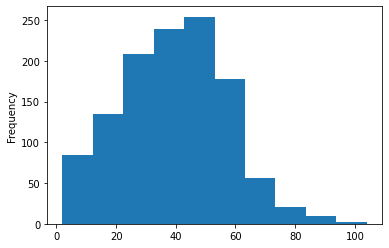

In [15]:
num_stops_for_every_route.plot.hist()

# Average route length

stops.txt: stop_lon, stop_lat

routes.txt: route_id

result: {route_id: [(stop_lon, stop_lat)] for route_id in route_ids}

In [16]:
# wgs84 is in degrees, pseudo mercator is in meters
wgs84 = pyproj.CRS('EPSG:4326')
pseudo_mercator = pyproj.CRS('EPSG:3857')
project = pyproj.Transformer.from_crs(wgs84, pseudo_mercator, always_xy=True).transform

def transformer(p: Point):
    return transform(project, p)

In [17]:
# def z(x):
#     res = []
#     for stop in x:
#         df = stops[stops.stop_id == stop]
#         res.append((df.stop_lon.iloc[0], df.stop_lat.iloc[0]))
#     return res

# route_to_stops.apply(z)

In [18]:
# TODO this is rather slow too
def z(x):
    res = []
    for stop in x:
        df = stops[stops.stop_id == stop]
        x_c = df.stop_lon.iloc[0]
        y_c = df.stop_lat.iloc[0]
        res.append(transformer(Point(x_c, y_c)))
    return res

route_stop_coords = route_to_stops.apply(z)
route_stop_coords

route_id
0       [POINT (8581937.473719167 3357553.47980293), P...
1       [POINT (8588110.028164163 3344921.146539369), ...
2       [POINT (8563883.233424349 3327151.778796668), ...
3       [POINT (8567644.38505978 3336016.868613827), P...
4       [POINT (8588384.87598693 3343879.174672297), P...
                              ...                        
1265    [POINT (8572433.906151159 3342286.916402147), ...
1266    [POINT (8602521.67208124 3328759.726609009), P...
1267    [POINT (8602888.469803404 3314096.779721026), ...
1268    [POINT (8562762.023513079 3327757.827654622), ...
1269    [POINT (8578133.352760287 3340661.463687472), ...
Length: 1187, dtype: object

In [19]:
route_lengths = route_stop_coords.apply(lambda x: LineString(x).length)
route_lengths

route_id
0        12877.486982
1        30744.084545
2         8262.196860
3        22570.834831
4        45091.306219
            ...      
1265     46386.475744
1266    197980.508379
1267     92415.473493
1268    349226.089849
1269    151362.127355
Length: 1187, dtype: float64

In [20]:
# Average route length in meters
route_lengths.mean()

107266.6276246442

<AxesSubplot:ylabel='Frequency'>

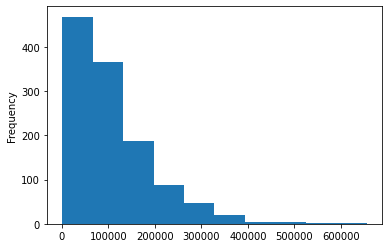

In [21]:
route_lengths.plot.hist()

# Average distance between stops

In [22]:
def calc_distances(x):
    '''
    input: [(float, float)]
        a list of coordinates
    output: [float]
        the distances between each coordinates
    '''
    return [Point(a).distance(Point(b)) for a, b in zip(x, x[1:])]

In [23]:
route_stop_dists = route_stop_coords.apply(calc_distances)
route_stop_dists

route_id
0       [321.9643107629447, 254.33472327080472, 328.21...
1       [1077.611570766103, 1308.7206422144516, 682.18...
2       [2020.2658950779826, 623.7750065142687, 859.07...
3       [711.0090631376837, 838.3606140627169, 182.089...
4       [1308.7206422144516, 1278.836850338327, 821.24...
                              ...                        
1265    [2792.408894764671, 376.9216673730307, 4450.98...
1266    [605.9380301503602, 376.8051193827688, 329.656...
1267    [16880.945352753235, 790.2810089899889, 863.78...
1268    [17988.341875594277, 334.8003939635251, 750.04...
1269    [8208.067761220836, 282.8000845912758, 694.153...
Length: 1187, dtype: object

In [24]:
route_avg_stop_dists = route_stop_dists.apply(np.mean)
route_avg_stop_dists

route_id
0        677.762473
1        683.201879
2       1377.032810
3        835.956846
4       1503.043541
           ...     
1265    2016.803293
1266    3245.582105
1267    2009.032032
1268    3968.478294
1269    2702.895131
Length: 1187, dtype: float64

In [25]:
# Global average distance between stops (TODO: what units?)
route_avg_stop_dists.mean()

2490.817967252001

<AxesSubplot:ylabel='Frequency'>

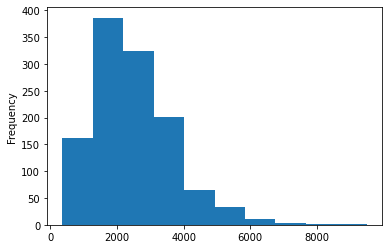

In [26]:
route_avg_stop_dists.plot.hist()

<AxesSubplot:ylabel='Frequency'>

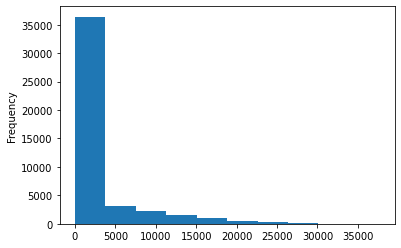

In [27]:
# The individual distances between every stops in every route
route_stop_dists.explode().plot.hist()

# Median bus speed

We can calculate an average speed (displacement/time) for every trip between every stop. That means we can plot a speed-time graph (time series showing how speed varies) for every trip

But that's probably too granular, so we can calculate a single average speed for the entire trip. That means we'll have an average speed for every single trip. This is one-dimensional data and can be plotted on a histogram.

The global median bus speed can be calculated by taking the median "average speed" from every single trip.

In [28]:
# stop_times has time but we need displacement as well
stop_times_with_coords = stop_times.join(
    stops[['stop_id', 'stop_lat', 'stop_lon']], on='stop_id', lsuffix='_times'
)
stop_times_with_coords

,trip_id,arrival_time,departure_time,stop_id_times,stop_sequence,stop_id,stop_lat,stop_lon
0,1_07_00,07:00:00,07:00:00,23,0,23.0,28.758318,77.148305
1,1_07_00,07:03:45,07:03:45,24,1,24.0,28.750112,77.150774
2,1_07_00,07:08:20,07:08:20,25,2,25.0,28.740200,77.154000
3,1_07_00,07:10:43,07:10:43,26,3,26.0,28.735084,77.155874
4,1_07_00,07:12:51,07:12:51,27,4,27.0,28.731117,77.158967
...,...,...,...,...,...,...,...,...
2250285,1268_21_30,24:50:16,24:50:16,371,84,371.0,28.604417,76.932400
2250286,1268_21_30,24:53:12,24:53:12,372,85,372.0,28.606975,76.939310
2250287,1268_21_30,24:55:25,24:55:25,1736,86,1753.0,28.698896,77.306292
2250288,1268_21_30,25:02:21,25:02:21,1738,87,1755.0,28.700396,77.295624


In [29]:
# today will change based on the current time but it doesn't matter, because I only care about
# change in time
today = date.today()
str(today)

'2021-11-23'

In [30]:
splitted = stop_times_with_coords.departure_time.str.split(':')

In [31]:
splitted

0          [07, 00, 00]
1          [07, 03, 45]
2          [07, 08, 20]
3          [07, 10, 43]
4          [07, 12, 51]
               ...     
2250285    [24, 50, 16]
2250286    [24, 53, 12]
2250287    [24, 55, 25]
2250288    [25, 02, 21]
2250289    [25, 06, 54]
Name: departure_time, Length: 2250290, dtype: object

In [32]:
def fix_over_24h(hms):
    hour_int = int(hms[0])
    if hour_int >= 24:
        date = today + timedelta(days=1)
    else:
        date = today
    hour = hour_int % 24
    min_ = int(hms[1])
    sec = int(hms[2])
    return datetime.combine(date, dt.time(hour, min_, sec))

In [33]:
fixed = splitted.apply(fix_over_24h)

In [34]:
stop_times_with_coords['departure_time_fixed'] = fixed

In [35]:
# TODO this one is really slow, see if it's possible to vectorize
def calc_speed(x):
    times = x['departure_time_fixed'].replace().astype('datetime64[ns]')
    delta_times = [(b - a).total_seconds() for a, b in zip(times, times[1:])]
    coords = [transformer(Point(x, y)) for x, y in zip(x['stop_lon'], x['stop_lat'])]
    displacements = [b.distance(a) for a, b in zip(coords, coords[1:])]
    speeds = [
        displacement / delta_time
        for displacement, delta_time in zip(displacements, delta_times)
        if delta_time != 0
    ]
    return speeds
    
speed_between_stops = stop_times_with_coords.groupby('trip_id').apply(calc_speed)
speed_between_stops

trip_id
0_20_20    [4.734769275925657, 4.7099022827926795, 4.8266...
0_20_30    [4.734769275925657, 4.7099022827926795, 4.8266...
0_20_40    [4.734769275925657, 4.7099022827926795, 4.8266...
0_20_50    [4.734769275925657, 4.7099022827926795, 4.8266...
0_21_00    [4.734769275925657, 4.7099022827926795, 4.8266...
                                 ...                        
9_21_10    [4.775418334656012, 4.7574275151170795, 4.7758...
9_21_20    [4.775418334656012, 4.7574275151170795, 4.7758...
9_21_30    [4.775418334656012, 4.7574275151170795, 4.7758...
9_21_40    [4.775418334656012, 4.7574275151170795, 4.7758...
9_21_50    [4.775418334656012, 4.7574275151170795, 4.7758...
Length: 50355, dtype: object

In [36]:
# speed_between_stops_idx = speed_between_stops.apply(lambda x: list(enumerate(x)))

In [37]:
# speed_between_stops_idx

In [38]:
# speed_between_stops_df = pd.DataFrame(speed_between_stops_idx, columns=['speed']).explode('speed')
# speed_between_stops_df.reset_index(inplace=True)
# speed_between_stops_df

In [39]:
# speed_between_stops_df['idx'] = speed_between_stops_df.speed.map(lambda x: x[0])
# speed_between_stops_df['speed'] = speed_between_stops_df.speed.map(lambda x: x[1])

In [40]:
# rand_trips = np.random.choice(speed_between_stops_df.trip_id.unique(), 10)
# rand_trips

In [41]:
#sub = speed_between_stops_df[speed_between_stops_df.trip_id.isin(rand_trips)]
#sub

In [42]:
# This plots the average speed of the buses along their trips
# y-axis: average speed
# x-axis: stop number
#sns.lineplot(x=sub.idx, y=sub.speed, hue=sub.trip_id)

In [43]:
avg_speed_between_stops = speed_between_stops.apply(np.mean)
avg_speed_between_stops

trip_id
0_20_20    4.767269
0_20_30    4.767269
0_20_40    4.767269
0_20_50    4.767269
0_21_00    4.767269
             ...   
9_21_10    4.767423
9_21_20    4.767423
9_21_30    4.767423
9_21_40    4.767423
9_21_50    4.767423
Length: 50355, dtype: float64

<AxesSubplot:ylabel='Frequency'>

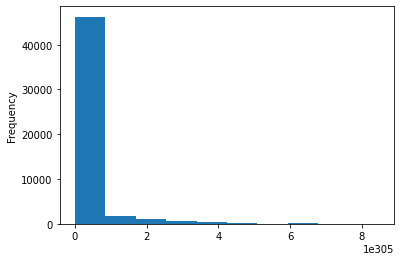

In [44]:
avg_speed_between_stops.plot.hist()

In [45]:
# Global median bus speed
avg_speed_between_stops.median()

62.42350482150976

# Number of links

# Number of nodes

# Network diameter

In [46]:
def z(x):
    res = []
    for stop in x:
        df = stops[stops.stop_id == stop]
        res.append((df.stop_lon.iloc[0], df.stop_lat.iloc[0]))
    return res

route_stop_coords = route_to_stops.apply(z)
route_stop_coords

route_id
0       [(77.09285600000003, 28.857752), (77.095745999...
1       [(77.14830500000002, 28.758318), (77.150774, 2...
2       [(76.930672, 28.618288), (76.94478225753659, 2...
3       [(76.96445899999998, 28.688172), (76.9708, 28....
4       [(77.150774, 28.750112), (77.154, 28.7402), (7...
                              ...                        
1265    [(77.00748399999998, 28.73757100000001), (77.0...
1266    [(77.277767, 28.630967), (77.28215, 28.6338), ...
1267    [(77.281062, 28.515290000000004), (77.224176, ...
1268    [(76.9206, 28.623067), (77.06764, 28.681877000...
1269    [(77.058683, 28.724767), (77.1274, 28.70132000...
Length: 1187, dtype: object

In [47]:
route_stop_coords_dict = route_stop_coords.to_dict()

In [48]:
g = nx.from_dict_of_lists(route_stop_coords_dict)

In [49]:
nx.algorithms.distance_measures.diameter(g)

10

## Trying to use Point instead of coord... but too slow

In [50]:
route_stop_coords_df = pd.DataFrame(route_stop_coords, columns=['coords']).explode('coords')
route_stop_coords_df

,coords
route_id,
0,"(77.09285600000003, 28.857752)"
0,"(77.09574599999998, 28.857652)"
0,"(77.097951, 28.857128000000003)"
0,"(77.09790699999998, 28.85454600000001)"
0,"(77.097849, 28.85177100000001)"
...,...
1269,"(77.13964, 28.71616)"
1269,"(77.13884, 28.71348)"
1269,"(77.13649000000002, 28.70992)"


In [51]:
route_stop_coords_df.coords = route_stop_coords_df.coords.apply(Point)

In [52]:
route_stop_coords_gdf = gpd.GeoDataFrame(route_stop_coords_df)
route_stop_coords_gdf

,coords
route_id,
0,POINT (77.09285600000003 28.857752)
0,POINT (77.09574599999998 28.857652)
0,POINT (77.09795099999999 28.857128)
0,POINT (77.09790699999998 28.85454600000001)
0,POINT (77.097849 28.85177100000001)
...,...
1269,POINT (77.13964 28.71616)
1269,POINT (77.13884 28.71348)
1269,POINT (77.13649000000002 28.70992)


In [53]:
route_stop_coords_gdf.geometry = route_stop_coords_gdf.coords

In [54]:
G = momepy.gdf_to_nx(route_stop_coords_gdf)

In [55]:
#nx.draw(G)

# Network density

In [56]:
nx.classes.function.density(g)

0.0033170887927784468